In [1]:
import pandas as pd
import json
import networkx as nx
from itertools import combinations
import re
import time
from datetime import datetime

In [2]:
%load_ext autotime

time: 0 ns


In [3]:
path = r'D:\Yelp\charlotte_2016.csv'

time: 0 ns


In [4]:
df = pd.read_csv(path, index_col=0)

time: 906 ms


In [53]:
df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_business,review_count,...,categories,hours,review_id,user_id,stars,useful,funny,cool,text,date
8,0pOlmHVeidsh63iAWdTAfg,Hendrick Motors of Charlotte - Mercedes-Benz,5201 E Independence Blvd,Charlotte,NC,28212.0,35.188018,-80.758758,2.5,32,...,"Auto Repair, Car Dealers, Automotive","{'Monday': '0:0-0:0', 'Tuesday': '7:30-19:0', ...",VyiezkRspGtuG68_rDYp3A,A0R17nyHQ9SiqQjtnsP33g,1.0,5,0,0,Mercedes used to be such a great brand with ex...,2016-12-23 03:54:01
37,0pOlmHVeidsh63iAWdTAfg,Hendrick Motors of Charlotte - Mercedes-Benz,5201 E Independence Blvd,Charlotte,NC,28212.0,35.188018,-80.758758,2.5,32,...,"Auto Repair, Car Dealers, Automotive","{'Monday': '0:0-0:0', 'Tuesday': '7:30-19:0', ...",JjEQm2ToCdk5aAd8OAkEBQ,hpSViZNe-5eZaVSgi9LkZw,1.0,9,0,0,Horrible experience! Purchased a ML350 from he...,2016-02-14 04:09:06
42,-qjn24n8HYF6It9GQrQntw,Five Guys Burgers and Fries,2130 E Arbors Dr,Charlotte,NC,28262.0,35.338070,-80.757397,4.0,15,...,"Fast Food, American (New), Restaurants, Burgers","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",5Xn44MB8m064N4Zn1VppIA,17TiV5o3EsIIbyFgSpBmXg,4.0,0,0,0,Always good fresh juicy burgers. They are a bi...,2016-08-13 04:18:40
44,-qjn24n8HYF6It9GQrQntw,Five Guys Burgers and Fries,2130 E Arbors Dr,Charlotte,NC,28262.0,35.338070,-80.757397,4.0,15,...,"Fast Food, American (New), Restaurants, Burgers","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",IssjZBe_Y8S_QFcjUbdvVA,JeiCye0js6hLJdcREOu5bQ,3.0,1,0,0,"FYI, this place is now closed. No idea what h...",2016-12-06 16:29:59
48,-qjn24n8HYF6It9GQrQntw,Five Guys Burgers and Fries,2130 E Arbors Dr,Charlotte,NC,28262.0,35.338070,-80.757397,4.0,15,...,"Fast Food, American (New), Restaurants, Burgers","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",IRgRCDwyNRz2cFyyuuFRtw,sdLns7062kz3Ur_b8wgeYw,5.0,1,0,0,These folks gave me a warm and fuzzy feeling i...,2016-01-11 23:54:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384684,_JA3TLF5JJ95mthVwEdFuw,Steak ’n Shake,1926 Sardis Rd N,Charlotte,NC,28270.0,35.140920,-80.732982,2.0,88,...,"Restaurants, Burgers, Fast Food, Diners, Break...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",mKFAQcB98K0ZB4Jr22TETA,CCE-S9fOl6oZgiaPMi9TXA,1.0,0,0,0,If I could give these people 0 stars I would. ...,2016-03-13 06:41:19
384687,_JA3TLF5JJ95mthVwEdFuw,Steak ’n Shake,1926 Sardis Rd N,Charlotte,NC,28270.0,35.140920,-80.732982,2.0,88,...,"Restaurants, Burgers, Fast Food, Diners, Break...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",_hNxJfkRUsCCU3XmmWoo5Q,jJAi1T5DUSwuccjafLXTHQ,1.0,0,0,0,"The line took forever, order and pay for our f...",2016-11-18 01:12:36
384703,_JA3TLF5JJ95mthVwEdFuw,Steak ’n Shake,1926 Sardis Rd N,Charlotte,NC,28270.0,35.140920,-80.732982,2.0,88,...,"Restaurants, Burgers, Fast Food, Diners, Break...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",GR8-fBq9sM2WChsjeiq6vw,QRNzgxnW4uVkWZNkt9mH8w,1.0,0,0,0,I have been told by many people that this is ...,2016-10-13 01:15:55
384709,_JA3TLF5JJ95mthVwEdFuw,Steak ’n Shake,1926 Sardis Rd N,Charlotte,NC,28270.0,35.140920,-80.732982,2.0,88,...,"Restaurants, Burgers, Fast Food, Diners, Break...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",8inE0lJgX6BtB64lrSzukQ,QRNzgxnW4uVkWZNkt9mH8w,5.0,0,0,0,Holy cow!!! I am not a fan of eating out but t...,2016-09-16 01:32:59


time: 141 ms


In [5]:
df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_business', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'review_id', 'user_id',
       'stars_review', 'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')

time: 0 ns


In [6]:
df.rename(columns={'stars_review': 'stars'}, inplace=True)

time: 0 ns


In [7]:
df['date'] =  pd.to_datetime(df['date'])

time: 31 ms


In [8]:
df.shape

(51261, 22)

time: 0 ns


In [9]:
groups = df.groupby('business_id')
print(len(groups))

5954
time: 31 ms


In [10]:
alpha = 6

time: 0 ns


In [11]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Started at Time =", current_time)

count_review = dict()
G = nx.Graph()
for index, g in groups: 
    
    def filter_on_date(g):
        result = []
        def get_time_diff(combination):
            diff = combination.iloc[0].date - combination.iloc[-1].date
            return diff.days
        
        edges = list(combinations(g.user_id, 2))

        for e in edges: 
            combination = g[g.user_id.isin(e)]
            diff = get_time_diff(combination)
            if abs(diff) > alpha:
                continue
            else:
                result.append(e)
        return result, list(set(g.business_id))[0]
    
    def filter_on_rating(g):
        result = []
        rating_g = g.groupby('stars')
        
        for i, r_g in rating_g:
            result.append(r_g)
        return result
    
    rating_g = filter_on_rating(g)
    for g in rating_g: 
        date_g, product_id = filter_on_date(g)
        if len(date_g) > 0:
            for e in date_g:
                u = e[0]
                v = e[1]
                G.add_edge(u, v)
                
                if (u,v, product_id) in count_review.keys():
                    count_review[(u,v, product_id)] += 1
                else:
                    count_review[(u,v, product_id)] = 1

Started at Time = 13:38:37
time: 8min 20s


In [12]:
def filter_cliques(cliques, k):
    result = []
    for clique in cliques:
        if len(clique) >= k:
            result.append(clique)
    return result

time: 0 ns


In [13]:
cliques = list(nx.find_cliques(G))
cliques = filter_cliques(cliques, k=2)
print(len(cliques))

8602
time: 156 ms


In [14]:
beta = 2/3

time: 0 ns


In [15]:
def merge_cliques(cliques):
    
    def how_many_el_are_equal(clique, clique_search):
        result = 0
        
        for element in clique:
            if element in clique_search:
                result+=1        
        return result
        
    def get_arteficial_group(result_df):
        result = []
        arteficial_groups = result_df.groupby('common_elements').arteficial_grp.sum().values
        
        for group in arteficial_groups:
            numbers = re.findall('[0-9]+', group)
            result.append(list(set(numbers)))
        return result
    
    result = []
    k = 3
    proccesed_cliques = dict()
    for clique in cliques:
        proccesed_cliques.update({str(clique):1})
        for clique_search in cliques:
            
            # Grenzfälle
            if clique == clique_search:
                continue
            if str(clique_search) in proccesed_cliques:
                continue
            
            num_equal = how_many_el_are_equal(clique, clique_search)
            treshold_clique = ((num_equal/len(clique)))
            treshold_clique_search = ((num_equal/len(clique_search)))
            #print(treshold_clique, treshold_clique_search)  
            
            # Grenzfall
            if treshold_clique == 1 or treshold_clique_search == 1:
                continue
            
            if treshold_clique>=beta or treshold_clique_search>=beta:
  
                common_elements = [x for x,y in zip(clique, clique_search) if x==y]
                arteficial_grp = set(clique + clique_search)              
               
                #print(clique, clique_search, num_equal,  True, arteficial_grp, common_elements)
                result.append({'arteficial_grp' : str(arteficial_grp), 'common_elements' : str(common_elements)})
    if len(result) > 0:
        result_df = pd.DataFrame(result) 
        result = get_arteficial_group(result_df)
    return result
    

time: 31 ms


Draw Graph

Create Dataset

In [16]:
artificial_groups = merge_cliques(cliques)
natural_groups = cliques
print('natural_groups', len(natural_groups))
print('artificial_groups', len(artificial_groups))

natural_groups 8602
artificial_groups 1000
time: 1min 45s


In [17]:
def get_df_result(artificial_groups, natural_groups):
    df_dict = []
    #i = 0
    for i, group in enumerate(natural_groups):
        for reviewer_id in group:
            df_dict.append({'reviewer_id': reviewer_id, 'group_id': i, 'group_len': len(group), 'group_type': 'n'})
    
    for f, group in enumerate(artificial_groups):
        for reviewer_id in group:
            df_dict.append({'reviewer_id': reviewer_id, 'group_id': f+i+1, 'group_len': len(group), 'group_type': 'a'})

    df_result = pd.DataFrame(df_dict)
    
    
    return df_result

time: 16 ms


In [18]:
df_result = get_df_result(artificial_groups, natural_groups) 
df_result.head(1)

,reviewer_id,group_id,group_len,group_type
0,pbBSvO5mENr0mdl7JY-ZjA,0,2,n


time: 78 ms


In [19]:
def plot_diff_products(df_final):
    title = 'How many reviews has each group have in common'
    df = df_final.drop_duplicates(subset='group_id')
    df.product_count.plot(kind='bar', x='group_id')
    plt.plot()

time: 0 ns


In [20]:
df_result.columns

Index(['reviewer_id', 'group_id', 'group_len', 'group_type'], dtype='object')

time: 0 ns


In [21]:
df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_business', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'review_id', 'user_id', 'stars',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')

time: 0 ns


In [22]:
df_result.rename(columns={'reviewer_id': 'user_id'}, inplace=True)

time: 0 ns


In [62]:
df_final = df.merge(df_result, on='user_id',  how='left')

time: 281 ms


In [64]:
df_final.to_csv('charlotte_2016.csv')

time: 13 s


In [ ]:
262215

In [25]:
df.shape

(51261, 22)

time: 0 ns


In [26]:
df_final.shape

(245273, 25)

time: 0 ns


In [27]:
df_final.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_business', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'review_id', 'user_id', 'stars',
       'useful', 'funny', 'cool', 'text', 'date', 'group_id', 'group_len',
       'group_type'],
      dtype='object')

time: 0 ns


In [43]:
df_final

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_business,review_count,...,useful,funny,cool,text,date,group_id,group_len,group_type,occurances,products_count
0,0pOlmHVeidsh63iAWdTAfg,Hendrick Motors of Charlotte - Mercedes-Benz,5201 E Independence Blvd,Charlotte,NC,28212.0,35.188018,-80.758758,2.5,32,...,9,0,0,Horrible experience! Purchased a ML350 from he...,2016-02-14 04:09:06,5284,2,n,2,1.0
1,w3PwDEbI0EDx4YI_BkFhIA,Portofino's,"5126 Park Rd, Ste 1c",Charlotte,NC,28209.0,35.160557,-80.850104,4.0,233,...,0,0,0,Fantastic little place! Verdict was out when w...,2016-12-31 04:56:06,5284,2,n,2,1.0
2,w3PwDEbI0EDx4YI_BkFhIA,Portofino's,"5126 Park Rd, Ste 1c",Charlotte,NC,28209.0,35.160557,-80.850104,4.0,233,...,0,0,0,I write this review reluctantly as I do not wa...,2016-12-29 16:27:39,5284,2,n,2,1.0
3,-qjn24n8HYF6It9GQrQntw,Five Guys Burgers and Fries,2130 E Arbors Dr,Charlotte,NC,28262.0,35.338070,-80.757397,4.0,15,...,0,0,0,Always good fresh juicy burgers. They are a bi...,2016-08-13 04:18:40,209,4,n,4,1.0
4,NFm869_w6cvVaWaNpAzjeA,Soul Gastrolounge,1500-B Central Ave,Charlotte,NC,28205.0,35.220275,-80.813323,4.0,1077,...,0,0,0,This place never disappoints! It's the perfect...,2016-04-03 02:15:43,209,4,n,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245268,OgANEur7Bt8YJSd2uSm6yA,Pizza Hut,7705 S Tryon St E,Charlotte,NC,28217.0,35.147999,-80.924835,1.5,61,...,0,0,0,"To start, I would absolutely give negative sta...",2016-02-15 04:36:51,8415,2,n,2,1.0
245269,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,0,0,0,Was here with friends some months ago. A great...,2016-05-19 18:56:55,5985,2,n,2,1.0
245270,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,0,0,0,Very accommodating to my gluten free diet.\nGr...,2016-05-17 18:26:20,5985,2,n,2,1.0
245271,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,0,0,0,Amazing menu selections - especially daily spe...,2016-12-05 01:22:15,3347,2,n,2,1.0


time: 687 ms


In [46]:
del df_final['occurances']

time: 32 ms


In [47]:
del df_final['products_count']

time: 0 ns


In [52]:
df_final

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_business,review_count,...,user_id,stars,useful,funny,cool,text,date,group_id,group_len,group_type
0,0pOlmHVeidsh63iAWdTAfg,Hendrick Motors of Charlotte - Mercedes-Benz,5201 E Independence Blvd,Charlotte,NC,28212.0,35.188018,-80.758758,2.5,32,...,hpSViZNe-5eZaVSgi9LkZw,1.0,9,0,0,Horrible experience! Purchased a ML350 from he...,2016-02-14 04:09:06,5284,2,n
1,w3PwDEbI0EDx4YI_BkFhIA,Portofino's,"5126 Park Rd, Ste 1c",Charlotte,NC,28209.0,35.160557,-80.850104,4.0,233,...,hpSViZNe-5eZaVSgi9LkZw,5.0,0,0,0,Fantastic little place! Verdict was out when w...,2016-12-31 04:56:06,5284,2,n
2,w3PwDEbI0EDx4YI_BkFhIA,Portofino's,"5126 Park Rd, Ste 1c",Charlotte,NC,28209.0,35.160557,-80.850104,4.0,233,...,pU3Dd7ExICP1gfzzt1O7YQ,5.0,0,0,0,I write this review reluctantly as I do not wa...,2016-12-29 16:27:39,5284,2,n
3,-qjn24n8HYF6It9GQrQntw,Five Guys Burgers and Fries,2130 E Arbors Dr,Charlotte,NC,28262.0,35.338070,-80.757397,4.0,15,...,17TiV5o3EsIIbyFgSpBmXg,4.0,0,0,0,Always good fresh juicy burgers. They are a bi...,2016-08-13 04:18:40,209,4,n
4,NFm869_w6cvVaWaNpAzjeA,Soul Gastrolounge,1500-B Central Ave,Charlotte,NC,28205.0,35.220275,-80.813323,4.0,1077,...,17TiV5o3EsIIbyFgSpBmXg,5.0,0,0,0,This place never disappoints! It's the perfect...,2016-04-03 02:15:43,209,4,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245268,OgANEur7Bt8YJSd2uSm6yA,Pizza Hut,7705 S Tryon St E,Charlotte,NC,28217.0,35.147999,-80.924835,1.5,61,...,HXSrr0s9e_LsGTgkkKiclQ,1.0,0,0,0,"To start, I would absolutely give negative sta...",2016-02-15 04:36:51,8415,2,n
245269,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,D6ZUT5nVBWBWYiay5JhoMQ,5.0,0,0,0,Was here with friends some months ago. A great...,2016-05-19 18:56:55,5985,2,n
245270,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,yctC2JnkGRHxJpyZjqF7jA,5.0,0,0,0,Very accommodating to my gluten free diet.\nGr...,2016-05-17 18:26:20,5985,2,n
245271,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,FDcV4KRs9S7uTz8qEVNsOg,5.0,0,0,0,Amazing menu selections - especially daily spe...,2016-12-05 01:22:15,3347,2,n


time: 266 ms


In [28]:
df_occurances = df_final.groupby('group_id').business_id.value_counts().to_frame('occurances').reset_index()

time: 156 ms


In [29]:
df_occurances.columns

Index(['group_id', 'business_id', 'occurances'], dtype='object')

time: 0 ns


In [30]:
df_final_2 = df_final.merge(df_occurances, on=['group_id', 'business_id'])

time: 219 ms


In [31]:
df_final_2.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_business', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'review_id', 'user_id', 'stars',
       'useful', 'funny', 'cool', 'text', 'date', 'group_id', 'group_len',
       'group_type', 'occurances'],
      dtype='object')

time: 15 ms


In [32]:
df_final_2['ctn_products'] = df_final_2['occurances'] / df_final_2['group_len']

time: 15 ms


In [33]:
df_final_2.groupby(['group_id', 'business_id']).ctn_products.max().sort_values(ascending=False)[:10]

group_id  business_id           
1073      fvYvzoOHyfPrAiY3FX_PlQ    3.0
4906      6hZgMg9rnDCC0RBVRlkZwQ    3.0
4905      6hZgMg9rnDCC0RBVRlkZwQ    3.0
8562      zJRJX2-xnxHCUXA5WbBYPA    2.5
4816      hhoKM8RdfYo97Y72LqmOgw    2.5
4820      hhoKM8RdfYo97Y72LqmOgw    2.5
4817      hhoKM8RdfYo97Y72LqmOgw    2.5
4821      hhoKM8RdfYo97Y72LqmOgw    2.5
4819      hhoKM8RdfYo97Y72LqmOgw    2.5
4823      hhoKM8RdfYo97Y72LqmOgw    2.5
Name: ctn_products, dtype: float64

time: 172 ms


neu

In [34]:
df_final_2[(df_final_2.group_id==1388) & (df_final_2.business_id=='m5niZy68d2gTtVWz89elfA')]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_business,review_count,...,useful,funny,cool,text,date,group_id,group_len,group_type,occurances,ctn_products


time: 140 ms


In [35]:
grouped = df_final_2.groupby('group_id')

time: 0 ns


In [36]:
df_occurances = df_occurances.groupby('group_id').occurances.max().to_frame().reset_index()

time: 32 ms


In [37]:
df_final = df_final.merge(df_occurances, on='group_id')

time: 125 ms


In [38]:
df_final['products_count'] = df_final.occurances/df_final.group_len

time: 0 ns


In [39]:
df_final

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_business,review_count,...,useful,funny,cool,text,date,group_id,group_len,group_type,occurances,products_count
0,0pOlmHVeidsh63iAWdTAfg,Hendrick Motors of Charlotte - Mercedes-Benz,5201 E Independence Blvd,Charlotte,NC,28212.0,35.188018,-80.758758,2.5,32,...,9,0,0,Horrible experience! Purchased a ML350 from he...,2016-02-14 04:09:06,5284,2,n,2,1.0
1,w3PwDEbI0EDx4YI_BkFhIA,Portofino's,"5126 Park Rd, Ste 1c",Charlotte,NC,28209.0,35.160557,-80.850104,4.0,233,...,0,0,0,Fantastic little place! Verdict was out when w...,2016-12-31 04:56:06,5284,2,n,2,1.0
2,w3PwDEbI0EDx4YI_BkFhIA,Portofino's,"5126 Park Rd, Ste 1c",Charlotte,NC,28209.0,35.160557,-80.850104,4.0,233,...,0,0,0,I write this review reluctantly as I do not wa...,2016-12-29 16:27:39,5284,2,n,2,1.0
3,-qjn24n8HYF6It9GQrQntw,Five Guys Burgers and Fries,2130 E Arbors Dr,Charlotte,NC,28262.0,35.338070,-80.757397,4.0,15,...,0,0,0,Always good fresh juicy burgers. They are a bi...,2016-08-13 04:18:40,209,4,n,4,1.0
4,NFm869_w6cvVaWaNpAzjeA,Soul Gastrolounge,1500-B Central Ave,Charlotte,NC,28205.0,35.220275,-80.813323,4.0,1077,...,0,0,0,This place never disappoints! It's the perfect...,2016-04-03 02:15:43,209,4,n,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245268,OgANEur7Bt8YJSd2uSm6yA,Pizza Hut,7705 S Tryon St E,Charlotte,NC,28217.0,35.147999,-80.924835,1.5,61,...,0,0,0,"To start, I would absolutely give negative sta...",2016-02-15 04:36:51,8415,2,n,2,1.0
245269,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,0,0,0,Was here with friends some months ago. A great...,2016-05-19 18:56:55,5985,2,n,2,1.0
245270,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,0,0,0,Very accommodating to my gluten free diet.\nGr...,2016-05-17 18:26:20,5985,2,n,2,1.0
245271,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,0,0,0,Amazing menu selections - especially daily spe...,2016-12-05 01:22:15,3347,2,n,2,1.0


time: 266 ms


In [40]:
df_final.groupby('group_len').products_count.max().sort_values(ascending=True).plot(kind='line')

<AxesSubplot:xlabel='group_len'>

time: 610 ms


<AxesSubplot:xlabel='products_count'>

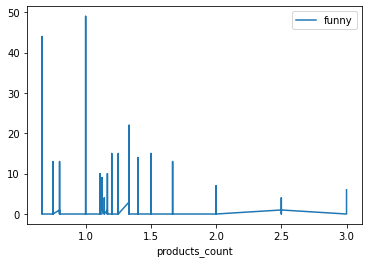

time: 718 ms


In [41]:
df_final.sort_values(by='products_count', ascending=True).plot(x='products_count', y='funny')

In [42]:
df_final

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_business,review_count,...,useful,funny,cool,text,date,group_id,group_len,group_type,occurances,products_count
0,0pOlmHVeidsh63iAWdTAfg,Hendrick Motors of Charlotte - Mercedes-Benz,5201 E Independence Blvd,Charlotte,NC,28212.0,35.188018,-80.758758,2.5,32,...,9,0,0,Horrible experience! Purchased a ML350 from he...,2016-02-14 04:09:06,5284,2,n,2,1.0
1,w3PwDEbI0EDx4YI_BkFhIA,Portofino's,"5126 Park Rd, Ste 1c",Charlotte,NC,28209.0,35.160557,-80.850104,4.0,233,...,0,0,0,Fantastic little place! Verdict was out when w...,2016-12-31 04:56:06,5284,2,n,2,1.0
2,w3PwDEbI0EDx4YI_BkFhIA,Portofino's,"5126 Park Rd, Ste 1c",Charlotte,NC,28209.0,35.160557,-80.850104,4.0,233,...,0,0,0,I write this review reluctantly as I do not wa...,2016-12-29 16:27:39,5284,2,n,2,1.0
3,-qjn24n8HYF6It9GQrQntw,Five Guys Burgers and Fries,2130 E Arbors Dr,Charlotte,NC,28262.0,35.338070,-80.757397,4.0,15,...,0,0,0,Always good fresh juicy burgers. They are a bi...,2016-08-13 04:18:40,209,4,n,4,1.0
4,NFm869_w6cvVaWaNpAzjeA,Soul Gastrolounge,1500-B Central Ave,Charlotte,NC,28205.0,35.220275,-80.813323,4.0,1077,...,0,0,0,This place never disappoints! It's the perfect...,2016-04-03 02:15:43,209,4,n,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245268,OgANEur7Bt8YJSd2uSm6yA,Pizza Hut,7705 S Tryon St E,Charlotte,NC,28217.0,35.147999,-80.924835,1.5,61,...,0,0,0,"To start, I would absolutely give negative sta...",2016-02-15 04:36:51,8415,2,n,2,1.0
245269,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,0,0,0,Was here with friends some months ago. A great...,2016-05-19 18:56:55,5985,2,n,2,1.0
245270,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,0,0,0,Very accommodating to my gluten free diet.\nGr...,2016-05-17 18:26:20,5985,2,n,2,1.0
245271,D2ojX9bvE0_-aIj9BhdZZA,300 East,300 East Blvd,Charlotte,NC,28203.0,35.210558,-80.856655,4.0,760,...,0,0,0,Amazing menu selections - especially daily spe...,2016-12-05 01:22:15,3347,2,n,2,1.0


time: 203 ms
